In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pwd 
%cd /content/drive/MyDrive/models/dino-main/
!nvidia-smi
!pip install timm==0.4.9
!pip install yacs
!pip install -U PyYAML
!pip install einops

Mounted at /content/drive
/content
/content/drive/MyDrive/models/dino-main
Wed Jan 25 19:21:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
             

In [9]:
import os
files='/content/drive/MyDrive/datasets/CRC/train/s1'
len(os.listdir(files))
# files

13060

In [ ]:

# Copyright (c) Facebook, Inc. and its affiliates.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
from google.colab import drive
drive.mount('/content/drive')
!pwd 
%cd drive/MyDrive/models/dino-main/
!nvidia-smi
!pip install timm==0.4.9
!pip install yacs
!pip install -U PyYAML
!pip install einops



# Copyright (c) Facebook, Inc. and its affiliates.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import sys
import pickle
import argparse

import torch
from torch import nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torchvision import models as torchvision_models
from torchvision import transforms as pth_transforms
from PIL import Image, ImageFile
import numpy as np
from dataset import SingleData
import utils
from utils2 import  LabelSmoothingCrossEntropyLoss, BatchHardTripletLoss, ImageReader, MPerClassSampler
from torchvision import datasets, transforms
import vision_transformer as vits
from eval_knn import extract_features
import math


def get_data_list(data_path, ratio=0.0):
    img_list = []
    for root, dirs, files in os.walk(data_path):
        if files == []:
            class_name = dirs
        elif dirs == []:
            for f in files:
                img_path = os.path.join(root, f)
                img_list.append(img_path)

    np.random.seed(1)
    train_img_list =img_list
    return class_name, train_img_list

# class OxfordParisDataset(torch.utils.data.Dataset):
#     def __init__(self, dir_main, dataset, split, transform=None, imsize=None):
#         if dataset not in ['roxford5k', 'rparis6k']:
#             raise ValueError('Unknown dataset: {}!'.format(dataset))

#         # loading imlist, qimlist, and gnd, in cfg as a dict
#         gnd_fname = os.path.join(dir_main, dataset, 'gnd_{}.pkl'.format(dataset))
#         with open(gnd_fname, 'rb') as f:
#             cfg = pickle.load(f)
#         cfg['gnd_fname'] = gnd_fname
#         cfg['ext'] = '.jpg'
#         cfg['qext'] = '.jpg'
#         cfg['dir_data'] = os.path.join(dir_main, dataset)
#         cfg['dir_images'] = os.path.join(cfg['dir_data'], 'jpg')
#         cfg['n'] = len(cfg['imlist'])
#         cfg['nq'] = len(cfg['qimlist'])
#         cfg['im_fname'] = config_imname
#         cfg['qim_fname'] = config_qimname
#         cfg['dataset'] = dataset
#         self.cfg = cfg

#         self.samples = cfg["qimlist"] if split == "query" else cfg["imlist"]
#         self.transform = transform
#         self.imsize = imsize

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, index):
#         path = os.path.join(self.cfg["dir_images"], self.samples[index] + ".jpg")
#         ImageFile.LOAD_TRUNCATED_IMAGES = True
#         with open(path, 'rb') as f:
#             img = Image.open(f)
#             img = img.convert('RGB')
#         if self.imsize is not None:
#             img.thumbnail((self.imsize, self.imsize), Image.ANTIALIAS)
#         if self.transform is not None:
#             img = self.transform(img)
#         return img, index


class OxfordParisDataset(torch.utils.data.Dataset):
    def __init__(self, class_name, img_list, transform=None,imsize=None):

      self.img_list = img_list
      self.class_name = class_name
      print(self.class_name)
      self.label_list = []
      for i in range(len(img_list)):
          pre_fix = self.img_list[i].split('/')[-1].split('_')[0]
          self.label_list.append(self.class_name.index(pre_fix))
      self.label_list = np.array(self.label_list)
      self.transform = transform


      self.samples = self.img_list
      self.transform = transform
      self.imsize = imsize

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        # path = os.path.join(self.cfg["dir_images"], self.samples[index] + ".jpg")
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        # with open(path, 'rb') as f:
        img = Image.open(self.img_list[index])
        img = img.convert('RGB')
        if self.imsize is not None:
            img.thumbnail((self.imsize, self.imsize), Image.ANTIALIAS)
        if self.transform is not None:
            img = self.transform(img)
        return img, index,self.img_list[index]

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,)+(index,))
        return tuple_with_path



def config_imname(cfg, i):
    return os.path.join(cfg['dir_images'], cfg['imlist'][i] + cfg['ext'])


def config_qimname(cfg, i):
    return os.path.join(cfg['dir_images'], cfg['qimlist'][i] + cfg['qext'])


if __name__ == '__main__':
    parser = argparse.ArgumentParser('Image Retrieval on revisited Paris and Oxford')
    parser.add_argument('--data_path', default='/content/drive/MyDrive/dataSets/oxbuild_images', type=str)
    parser.add_argument('--dataset', default='roxford5k', type=str, choices=['roxford5k', 'rparis6k'])
    parser.add_argument('--multiscale', default=False, type=utils.bool_flag)
    parser.add_argument('--imsize', default=224, type=int, help='Image size')
    # parser.add_argument('--pretrained_weights', default='/content/drive/MyDrive/models/dino-main/checkpoint 45k data-200ep/checkpoint0150.pth', type=str, help="Path to pretrained weights to evaluate.")
    # parser.add_argument('--pretrained_weights', default='/content/drive/MyDrive/models/dino-main/checkpoint 65K/checkpoint.pth', type=str, help="Path to pretrained weights to evaluate.")
    # parser.add_argument('--pretrained_weights', default='/content/drive/MyDrive/models/dino-main/checkpoint 512/checkpoint.pth', type=str, help="Path to pretrained weights to evaluate.")
    parser.add_argument('--pretrained_weights', default='/content/drive/MyDrive/models/dino-main/checkpoint.pth', type=str, help="Path to pretrained weights to evaluate.")
    # parser.add_argument('--pretrained_weights', default='/content/drive/MyDrive/models/dino-main/checkpoint-ViTB/checkpoint.pth', type=str, help="Path to pretrained weights to evaluate.")
    
    
    parser.add_argument('--use_cuda', default=True, type=utils.bool_flag)
    parser.add_argument('--arch', default='vit_small', type=str, help='Architecture')
    # parser.add_argument('--patch_size', default=16, type=int, help='Patch resolution of the model.')
    parser.add_argument('--patch_size', default=8, type=int, help='Patch resolution of the model.')
    parser.add_argument("--checkpoint_key", default="teacher", type=str,
        help='Key to use in the checkpoint (example: "teacher")')
    parser.add_argument('--num_workers', default=8, type=int, help='Number of data loading workers per GPU.')
    parser.add_argument("--dist_url", default="env://", type=str, help="""url used to set up
        distributed training; see https://pytorch.org/docs/stable/distributed.html""")
    parser.add_argument("--local_rank", default=1, type=int, help="Please ignore and do not set this argument.")
    args = parser.parse_args("")

    utils.init_distributed_mode(args)
    print("git:\n  {}\n".format(utils.get_sha()))
    print("\n".join("%s: %s" % (k, str(v)) for k, v in sorted(dict(vars(args)).items())))
    cudnn.benchmark = True

    # ============ preparing data ... ============
    transform = pth_transforms.Compose([
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    transformKNN = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    #################################################
    # data_path="/content/drive/MyDrive/dataSets/CRC/DINO-test-same/train"
    # data_path="/content/drive/MyDrive/dataSets/CRC/forDINO/train"
    data_path="/content/drive/MyDrive/datasets/CRC/train"
   
    # data_path="D:\\models\\CGD-master\\dataset\\img"
    # test_path="/content/drive/MyDrive/dataSets/CRC/fixed different test2"
    test_path="/content/drive/MyDrive/datasets/CRC/train"

    # test_path="/content/drive/MyDrive/dataSets/CRC/fixed same test"
    class_name, train_img_list = get_data_list(data_path,0.0)
    train_img_list=sorted(train_img_list)
    class_test_name, test_img_list = get_data_list(test_path,0.0)
    test_img_list=sorted(test_img_list)
    dataset_train=OxfordParisDataset(class_name, train_img_list, transform=transform)
    # train_sample = MPerClassSampler(train_data_set.label_list, batch_size=8)
    # data_loader_train = torch.utils.data.DataLoader(train_data_set, batch_sampler=train_sample, num_workers=8)
    # train_data_set = datasets.ImageFolder(data_path, transform=transform)
    # test_data_set = datasets.ImageFolder(test_path, transform=transform)
    dataset_query = OxfordParisDataset(class_test_name, test_img_list, transform=transform)
    # data_loader_query = torch.utils.data.DataLoader(test_data_set, batch_size=8, shuffle=False, num_workers=8)
    ##################################################
    
    # dataset_train = OxfordParisDataset(args.data_path, args.dataset, split="train", transform=transform, imsize=args.imsize)
    # dataset_query = OxfordParisDataset(args.data_path, args.dataset, split="query", transform=transform, imsize=args.imsize)
    # sampler = torch.utils.data.DistributedSampler(train_data_set, shuffle=False)
    sampler = torch.utils.data.DistributedSampler(dataset_train, shuffle=False)

    # sampler = torch.utils.data.Sampler(dataset_train)
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train,
        # train_data_set,
        # sampler=sampler,
        # sampler=train_sample,
        batch_size=1,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    data_loader_query = torch.utils.data.DataLoader(
        dataset_query,
        # test_data_set,
        batch_size=1,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    # print(f"train: {len(dataset_train)} imgs / query: {len(dataset_query)} imgs")
    # print(data_loader_train.dataset.samples)
    # ============ building network ... ============
    if "vit" in args.arch:
        model = vits.__dict__[args.arch](patch_size=args.patch_size, num_classes=0)
        print(f"Model {args.arch} {args.patch_size}x{args.patch_size} built.")
    elif "xcit" in args.arch:
        model = torch.hub.load('facebookresearch/xcit:main', args.arch, num_classes=0)
    elif args.arch in torchvision_models.__dict__.keys():
        model = torchvision_models.__dict__[args.arch](num_classes=0)
    else:
        print(f"Architecture {args.arch} non supported")
        sys.exit(1)
    if args.use_cuda:
        model.cuda()
    model.eval()

    # load pretrained weights
    if os.path.isfile(args.pretrained_weights):
        state_dict = torch.load(args.pretrained_weights, map_location="cpu")
        if args.checkpoint_key is not None and args.checkpoint_key in state_dict:
            print(f"Take key {args.checkpoint_key} in provided checkpoint dict")
            state_dict = state_dict[args.checkpoint_key]
        # remove `module.` prefix
        state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
        # remove `backbone.` prefix induced by multicrop wrapper
        state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
        msg = model.load_state_dict(state_dict, strict=False)
        print('Pretrained weights found at {} and loaded with msg: {}'.format(args.pretrained_weights, msg))
    elif args.arch == "vit_small" and args.patch_size == 16:
        print("Since no pretrained weights have been provided, we load pretrained DINO weights on Google Landmark v2.")
        model.load_state_dict(torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/dino_vitsmall16_googlelandmark_pretrain/dino_vitsmall16_googlelandmark_pretrain.pth"))
    else:
        print("Warning: We use random weights.")

    ############################################################################
    data_path="/content/drive/MyDrive/datasets/CRC/test"
    class_name, train_img_list = get_data_list(data_path,0.0)
    train_img_list=sorted(train_img_list)
    datasetKNN = ImageFolderWithPaths(data_path, transform=transformKNN)

    samplerkNN2 = torch.utils.data.DistributedSampler(datasetKNN, shuffle=False)
    data_loaderKNN = torch.utils.data.DataLoader(
        datasetKNN,
        sampler=samplerkNN2,
        # batch_size=64,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=True,
        shuffle=False
        
    )
    # dataset_train=OxfordParisDataset(class_name, train_img_list, transform=transformKNN)


    # Step 1: extract features
    print("###########",data_loader_query.dataset.img_list)
    torch.save(data_loaderKNN.dataset.imgs, 'img_namesAll.pt')
    train_features,train_label = extract_features(model, data_loaderKNN, args.use_cuda, multiscale=args.multiscale)
    # query_features,query_label = extract_features(model, data_loader_query, args.use_cuda, multiscale=args.multiscale)
    torch.save(train_features, 'train_featuresAll.pt')
    # torch.save(query_features, 'query_featuresAll.pt')
    torch.save(train_label, 'train_labelAll.pt')
    # torch.save(query_label, 'query_labelAll.pt')
    

    
    
    # print(train_features)
    # print(query_features)
    # if utils.get_rank() == 0:  # only rank 0 will work from now on
    #     # normalize features
    #     train_features = nn.functional.normalize(train_features, dim=1, p=2)
    #     query_features = nn.functional.normalize(query_features, dim=1, p=2)

        ############################################################################
        # Step 2: similarity
        # sim = torch.mm(train_features, query_features.T)
        # ranks = torch.argsort(-sim, dim=0).cpu().numpy()
        # torch.save(sim, 'sim.pt')
        # print(sim)

        # print(ranks)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/models/dino-main
Wed Aug 24 05:51:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |              

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Model vit_small 8x8 built.
Take key teacher in provided checkpoint dict
Pretrained weights found at /content/drive/MyDrive/models/dino-main/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
########### ['/content/drive/MyDrive/datasets/CRC/train/s1/s1_002_2_00.png', '/content/drive/MyDrive/datasets/CRC/train/s1/s1_002_2_010.png', '/content/drive/MyDrive/datasets/CRC/train/s1/s1_002_2_011.png', '/content/drive/MyDrive/datasets/CRC/train/s1/s1_002_2_012.png', '/content/drive/MyDrive/datasets/CRC/train/s1/s1_002_2_015.png', '/content/drive/MyDrive/datasets/CRC/train/s1/s1_002_2_08.png', '/content/drive/MyDrive/datasets/CRC/train/s1/s1_002_2_09.png', '/content/drive/MyDrive/datasets/CRC/train/s1/s1_002_2_10.png', '/content/drive/MyDrive/datasets/CRC/train/s1/s1_002_2_100.png', '

In [ ]:
import torch
import torch.nn as nn
# query_features2=torch.load('/content/drive/MyDrive/models/dino-main/train_featuresAll2.pt',map_location=torch.device('cpu'))
query_features=torch.load('/content/drive/MyDrive/models/dino-main/train_featuresAll2.pt',map_location=torch.device('cpu'))
test_img_list=torch.load('/content/drive/MyDrive/models/dino-main/img_namesAll.pt',map_location=torch.device('cpu'))
# query_features=torch.add(query_features,query_features2)/2
query_features = nn.functional.normalize(query_features, dim=1, p=2)

sim = torch.mm(query_features, query_features.T)


for i in range(len(test_img_list)):
        for j in range(len(test_img_list)):
            index1=test_img_list[i][0].rfind('/')
            index2=test_img_list[j][0].rfind('/')
            if test_img_list[i][0][index1+4:index1+7] == test_img_list[j][0][index2+4:index2+7] and i!=j:
                sim[i][j]=0

In [ ]:
query_features=torch.load('/content/drive/MyDrive/models/dino-main/train_featuresAll1.pt',map_location=torch.device('cpu'))
query_features2=torch.load('/content/drive/MyDrive/models/dino-main/train_featuresAll2.pt',map_location=torch.device('cpu'))
torch.add(query_features,query_features2)/2

tensor([[-1.6639,  1.0663, -3.7454,  ..., -1.7757,  2.4798, -0.9465],
        [-1.1955,  1.1438, -2.6882,  ...,  4.1138,  1.5833, -2.9635],
        [ 1.4346,  0.8521,  1.6457,  ..., -4.3720, -0.1092,  2.4655],
        ...,
        [-0.2030, -2.4791, -4.3858,  ..., -4.2261, -1.8649, -1.4411],
        [ 1.6400, -0.0090,  1.3999,  ..., -4.3852,  0.3050, -0.2648],
        [-0.3465, -1.9707, -2.0042,  ..., -3.1324, -1.2172, -0.9531]])

In [ ]:
z=torch.sort(sim, dim=1)

In [ ]:
z=z[0]

In [ ]:
z=z[:,-2]

In [ ]:
sorted(z)

In [ ]:
simNumpy=sim.cpu().numpy()
ranks = torch.argsort(-sim, dim=1).cpu().numpy()

# for i in range(300):
#     sim[i][i]=-100.0

# ranks2 = torch.argsort(-sim, dim=0).cpu().numpy()


count = 0

for i in range(1000):
    if ranks[i,1]<1000 :
        count +=1
print(count)        
for i in range(1000,2000):
    if (ranks[i,1]>1000 and ranks[i,1]<2000)  :
        count +=1
        
print(count)           
for i in range(2000,3000):
    if (ranks[i,1]>2000 and ranks[i,1]<3000 ):
        count +=1
print(count)  

precent=count/3000
print(precent)

778
1364
1874
0.6246666666666667


In [ ]:
en1=[]
for i in range(len(test_img_list)):
  en1.append((test_img_list[i][0],ranks[i,1],sim[i,ranks[i,1]]))


In [ ]:
en2=[]
for i in range(len(test_img_list)):
  en2.append((test_img_list[i][0],ranks[i,1],sim[i,ranks[i,1]]))


In [ ]:
en3=[]
for i in range(len(test_img_list)):
  en3.append((test_img_list[i][0],ranks[i,1],sim[i,ranks[i,1]]))


In [ ]:
from numpy import save
save('en1.npy', en1)

In [ ]:
from numpy import save
save('en2.npy', en2)

In [ ]:
from numpy import save
save('en3.npy', en3)

In [ ]:
%cd /content/drive/MyDrive/models/dino-main/
from numpy import load
# load array
en1 = load('en1.npy')
en2 = load('en2.npy')
en3 = load('en3.npy')


/content/drive/MyDrive/models/dino-main


In [ ]:
knn=[]
for i in range(len(en1)):
  # print(float(en1[i,2][-7:-1]),float(en2[i,2][-7:-1]),float(en1[i,2][-7:-1])>float(en2[i,2][-7:-1]))
  if float(en2[i,2][-7:-1]) > float(en3[i,2][-7:-1]):
    knn.append(en2[i,1])
  else:
    knn.append(en3[i,1])


In [ ]:
knn[-4]

'2699'

In [ ]:
count = 0

for i in range(1000):
    if int(knn[i])<1000:
        count +=1
print(count)        
for i in range(1000,2000):
    if int(knn[i])>1000 and int(knn[i])<2000 :
        count +=1
        
print(count)           
for i in range(2000,3000):
    if int(knn[i])>2000 and int(knn[i])<3000 :
        count +=1
print(count)  

precent=count/3000
print(precent)

789
1400
1980
0.66


In [ ]:
count = 0

for i in range(1000):
    if int(en2[i,1])<1000:
        count +=1
print(count)        
for i in range(1000,2000):
    if int(en2[i,1])>1000 and int(en2[i,1])<2000 :
        count +=1
        
print(count)           
for i in range(2000,3000):
    if int(en2[i,1])>2000 and int(en2[i,1])<3000 :
        count +=1
print(count)  

precent=count/3000
print(precent)

775
1380
1957
0.6523333333333333


In [ ]:
en1[2,1]

'1120'

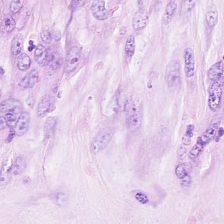

In [ ]:
image

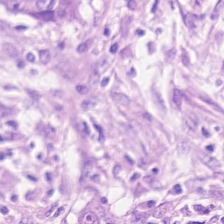

In [ ]:
image = Image.open(test_img_list[-1][0])

In [ ]:
query_features[2984]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/models/MA/'
!pwd
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/models/MA
/content/drive/MyDrive/models/MA
Wed Aug 24 05:18:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                    

In [ ]:
import numpy as np
import os
import torch
import sys
from ABE_M_model import ABE_M
from my_model import se_resnet50
from resnet import resnet50
from dataset import SingleData
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchsummary import summary


def get_data_list(data_path):
    img_list = []
    for root, dirs, files in os.walk(data_path):
        if files == []:
            class_name = dirs
        elif dirs == []:
            for f in files:
                img_path = os.path.join(root, f)
                img_list.append(img_path)
    return class_name, img_list


def test(test_loader, model, devicei):
    with torch.no_grad():
        model.eval()
        embedding_vec = []
        #test_img_list = []
        for batch_idx, (data, target, img_name) in enumerate(test_loader):
            data = data.to(device)
            outputs = model(data)
            #print(type(img_name)) 
            if batch_idx == 0:
                for i in range(len(outputs)):
                    output = outputs[i].cpu().numpy()
                    embedding_vec.append(output)
                labels = np.array(target)
                test_img_list = img_name
            else:
                for i in range(len(outputs)):
                    output = outputs[i].cpu().numpy()
                    embedding_vec[i] = np.concatenate((embedding_vec[i], output))
                labels = np.concatenate((labels, np.array(target)))
                test_img_list += img_name
    return embedding_vec, labels, list(test_img_list)


def Accuracy(embedding_vec, labels, test_img_list):
    print(labels)
    def _get_sim_matrix(embedding_vec, num_vec):
        sim_matrix = np.zeros((num_vec, num_vec))
        for i in range(len(embedding_vec)):
            sim_matrix += np.matmul(embedding_vec[i], embedding_vec[i].T)
        # if len(embedding_vec) > 1:
        #     # sim_matrix = sim_matrix / len(embedding_vec)
        #     sim_matrix = sim_matrix

            
        return sim_matrix
    #k_list = [1,2,4,8]
    k_list = [1]
    max_k = max(k_list)
    num_vec = embedding_vec[0].shape[0]
    print('total num of test image: {}'.format(num_vec))
    sim_mat = _get_sim_matrix(embedding_vec, num_vec)
    print("sim_mat=>",len(sim_mat[0]))
    result = np.zeros((num_vec, max_k+1))
    for i in range(len(test_img_list)):
        for j in range(len(test_img_list)):
            index1=test_img_list[i].rfind('/')
            index2=test_img_list[j].rfind('/')
            if test_img_list[i][index1+4:index1+7] == test_img_list[j][index2+4:index2+7] and i!=j :
                sim_mat[i][j]=0
    #f = open('result.txt', 'w')
    knn=[]
    for i in range(num_vec):
        temp_index = np.argsort(-1*sim_mat[i])[:max_k+1]
        for j in range(max_k+1):
            result[i][j] = labels[temp_index[j]]
            knn.append(temp_index[j])
            #f.write(test_img_list[i]+' '+test_img_list[temp_index[j]]+' '+str(sim_mat[i][temp_index[j]])+'\n')
    #f.close() 
    predicts = result[:,1]
    n_p = sum(labels==predicts)/num_vec
    num_class = len(set(labels))
    cnf_mat = np.zeros((num_class, num_class))
    for i in range(len(labels)):
        cnf_mat[int(labels[i])][int(predicts[i])] += 1

    #np.save('./model/cnf_mat.npy', cnf_mat)

    e = cnf_mat.diagonal()
    n_w = (e/cnf_mat.sum(axis=1)).mean()
    n_total = n_w*n_p
    accuracy = [(n_p,'np'), (n_w, 'nw'), (n_total, 'n_total')]
    '''
    recall = []
    for k in k_list:
        total = 0
        for i in range(num_vec):
            temp_list = result[i][1:k+1].tolist()
            if labels[i] in temp_list:
                total += 1
        recall.append((total/num_vec, k))
        print('Recall@k:{:.4f}, k={}'.format(total/num_vec, k))
    '''
    return accuracy ,predicts,test_img_list,result,sim_mat,knn
predicts=0
test_img_list=0
if __name__ == '__main__':
    # arg_len = len(sys.argv)
    # if arg_len != 2:
    #     raise Exception("Invalid argvs!")
    # weight_folder = sys.argv[1]
    weight_folder = '/content/drive/MyDrive/models/MA/ABE'
    model_name = 'ABE_M'
    #weight_type = weight_folder.split('/')[-1]

    model_dict = {'ABE_M':ABE_M, 'se_resnet':se_resnet50, 'resnet50':resnet50}
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    batch_size = 32
    #num_learner = 4
    
           
    #data
    transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])

    data_path = '/content/drive/MyDrive/datasets/CRC/test'
    class_name, img_list = get_data_list(data_path)
    print(img_list)
    test_dataset = SingleData(class_name, img_list, transform)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(test_dataset)
    f = open(weight_folder+model_name+'_'+'results.txt', 'w')
    
    sorted_weight_file = os.listdir(weight_folder)
   
    sorted_weight_file.sort()
    for weight_f in sorted_weight_file:
        if weight_f[-3:] != 'pth' or model_name not in weight_f:
            continue
        weight_path = os.path.join(weight_folder, weight_f)
        print(weight_path)

        model = model_dict[model_name]() #####################################
        model.load_state_dict(torch.load(weight_path))
        model.to(device)


        embedding_vec, labels, test_img_list = test(test_dataloader, model, device)
        print("####=>",test_img_list)
        accuracy_his,predicts,test_img_list1,result ,sim,MAKNN= Accuracy(embedding_vec, labels, test_img_list)
        print(accuracy_his)
        f.write(weight_f + str(accuracy_his)+'\n')

    f.close()


['/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_03.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_18.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_21.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_11.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_05.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_110.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_13.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_07.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_20.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_06.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_08.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_09.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_19.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_12.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_15.png', '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0

In [ ]:
MAKNN[1]

359

In [ ]:
KNNMA=[]
for i in range(len(MAKNN)):
  if i%2==0:
    continue
  KNNMA.append(MAKNN[i])
  

In [ ]:
KNNMA

In [ ]:
for i in range(3000):
  print(sim[i,])

In [ ]:
z=[]
for i in range(3000):
  z.append(sim[i,KNNMA[i]].item())

In [ ]:
z

[0.9126809239387512,
 0.842337965965271,
 0.8438178300857544,
 0.9367721676826477,
 0.9150320887565613,
 0.7679224610328674,
 0.9203780889511108,
 0.86363685131073,
 0.9492759704589844,
 0.9285057783126831,
 0.8550887703895569,
 0.9650419354438782,
 0.9118143916130066,
 0.9555500745773315,
 0.7687644958496094,
 0.9595372676849365,
 0.9571413397789001,
 0.8429078459739685,
 0.9492655992507935,
 0.8435126543045044,
 0.7915998697280884,
 0.5909596085548401,
 0.9628432989120483,
 0.8457938432693481,
 0.8206546306610107,
 0.7831093668937683,
 0.9501564502716064,
 0.6994845867156982,
 0.8822672963142395,
 0.7049919962882996,
 0.9805045127868652,
 0.8086603879928589,
 0.9225510358810425,
 0.905639111995697,
 0.8147019743919373,
 0.8967195153236389,
 0.8982942700386047,
 0.9469536542892456,
 0.9424735307693481,
 0.8221825957298279,
 0.9675306081771851,
 0.7981548309326172,
 0.9406540393829346,
 0.8447383046150208,
 0.7145100831985474,
 0.9137098789215088,
 0.6994615793228149,
 0.95828902721405

In [ ]:
test_img_list

['/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_03.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_18.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_21.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_11.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_05.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_110.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_13.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_07.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_20.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_06.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_08.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_09.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_19.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_12.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_15.png',
 '/content/drive/MyDrive/datasets/CRC/t

In [ ]:
for i in range(len(test_img_list)):
        for j in range(len(test_img_list)):
            index1=test_img_list[i][0].rfind('/')
            index2=test_img_list[j][0].rfind('/')
            if test_img_list[i][0][index1+4:index1+7] == test_img_list[j][0][index2+4:index2+7] and i!=j:
                sim[i][j]=0

In [ ]:
# simNumpy=sim.cpu().numpy()
ranks=[]
for i in range(3000):
  ranks.np.argsort(-1*sim[i])

# for i in range(300):
#     sim[i][i]=-100.0

# ranks2 = torch.argsort(-sim, dim=0).cpu().numpy()


count = 0

for i in range(1000):
    if ranks[i,1]<1000:
        count +=1
print(count)        
for i in range(1000,2000):
    if ranks[i,1]>1000 and ranks[i,1]<2000 :
        count +=1
        
print(count)           
for i in range(2000,3000):
    if ranks[i,1]>2000 and ranks[i,1]<3000 :
        count +=1
print(count)  

precent=count/3000
print(precent)

TypeError: ignored

In [ ]:
norm = np.linalg.norm(sim)
normal_array = sim/norm

In [ ]:
max(normal_array[2])

0.018257420858625098

In [ ]:
en3[0,0]

'/content/drive/MyDrive/datasets/CRC/test/s1/s1_001_0_00.png'

In [ ]:
count = 0
sortArr3=[]
for i in range(3000):
  if int(en3[i,1])<1000:
    sortArr3.append(1)
  if int(en3[i,1])>1000 and int(en3[i,1])<2000 :
    sortArr3.append(2)
  if int(en3[i,1])>2000 and int(en3[i,1])<3000 :
    sortArr3.append(0)    

In [ ]:
count = 0
sortArr2=[]
for i in range(3000):
  if int(en2[i,1])<1000:
    sortArr2.append(1)
  if int(en2[i,1])>1000 and int(en2[i,1])<2000 :
    sortArr2.append(2)
  if int(en2[i,1])>2000 and int(en2[i,1])<3000 :
    sortArr2.append(0)    

In [ ]:
count = 0
sortArr1=[]
for i in range(3000):
  if int(en1[i,1])<1000:
    sortArr1.append(1)
  if int(en1[i,1])>1000 and int(en1[i,1])<2000 :
    sortArr1.append(2)
  if int(en1[i,1])>2000 and int(en1[i,1])<3000 :
    sortArr1.append(0)    

In [ ]:
count = 0
sortArr3=[]
for i in range(3000):
  if int(en3[i,1])<1000:
    sortArr3.append(0)
  if int(en3[i,1])>1000 and int(en3[i,1])<2000 :
    sortArr3.append(1)
  if int(en3[i,1])>2000 and int(en3[i,1])<3000 :
    sortArr3.append(2)    

In [ ]:
# 312
# 012
count=0
for i in range(1000):
    if sortArr3[i]==0:
        count +=1
print(count)        
for i in range(1000,2000):
    if sortArr3[i]==1:
        count +=1
        
print(count)           
for i in range(2000,2999):
    if sortArr3[i]==2 :
        count +=1
print(count)  

precent=count/3000
print(precent)

786
1401
1982
0.6606666666666666


In [ ]:
# 312
# 012
count=0
for i in range(1000):
    if result[i,1]==1:
        count +=1
print(count)        
for i in range(1000,2000):
    if result[i,1]==2:
        count +=1
        
print(count)           
for i in range(2000,2999):
    if result[i,1]==0 :
        count +=1
print(count)  

precent=count/3000
print(precent)

186
390
657
0.219


In [ ]:
test_img_list2=torch.load('/content/drive/MyDrive/models/dino-main/img_namesAll.pt',map_location=torch.device('cpu'))

In [ ]:
imglist2=[]
for i in range(3000):
  imglist2.append(test_img_list2[i][0])

In [ ]:
test_img_list1

['/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_03.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_18.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_21.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_11.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_05.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_110.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_13.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_07.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_20.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_06.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_08.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_09.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_19.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_12.png',
 '/content/drive/MyDrive/datasets/CRC/test/s3/s3_016_0_15.png',
 '/content/drive/MyDrive/datasets/CRC/t

In [ ]:
imglist2.index(test_img_list1[2])

2028

In [ ]:
# MA=np.zeros(3000)
ABE=np.zeros(3000)


In [ ]:
for i in range(3000):
  # MA[i]=result[imglist2.index(test_img_list1[i]),1]
  ABE[i]=result[imglist2.index(test_img_list1[i]),1]


In [ ]:
simABE=np.zeros(3000)
for i in range(3000):
  simABE[i]=z[imglist2.index(test_img_list1[i])]

In [ ]:
simABE

array([3.99983656, 3.99991328, 3.99989885, ..., 3.99639517, 3.99470258,
       3.99894845])

In [ ]:
for i in MA:
  print(i)

2.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
2.0
0.0
0.0
2.0
0.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
2.0
0.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
0.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
1.0
0.0
2.0
2.0
2.0
0.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
0.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
0.0
2.0
2.0
0.0
2.0
0.0
2.0
2.0
0.0
0.0
2.0
0.0
0.0
2.0
0.0
2.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
0.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
0.0
2.0
2.0
2.0
2.0
0.0
2.0
0.0
2.0
0.0
1.0
0.0
2.0
2.0
0.0
2.0


In [ ]:
312
012


In [ ]:
count=0
for i in range(1000,2000):
  if ABE[i]==0:
    count+=1
count

433

In [ ]:
count=0
for i in range(2000,3000):
  if ABE[i]==1:
    count+=1
count

638

In [ ]:
count=0
for i in range(1000):
  if ABE[i]==2:
    count+=1
count

444

In [ ]:
MA2

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
for i in range(3000):
  if MA[i]==0:
    MA[i]=1
  elif MA[i]==1:
    MA[i]=2
  elif MA[i]==2:
    MA[i]=0
  

In [ ]:
# 312
# 012
count=0
for i in range(1000):
    if sortArr3[i]==1:
        count +=1
print(count)        
for i in range(1000,2000):
    if sortArr3[i]==2:
        count +=1
        
print(count)           
for i in range(2000,2999):
    if sortArr3[i]==0 :
        count +=1
print(count)  

precent=count/3000
print(precent)

In [ ]:
rr=np.zeros(3000)
for i in range(1000):
  if sortArr3[i]==0:
    rr[i]+=1
  if ABE[i]==0:
    rr[i]+=1
  if sortArr2[i]==0:
    rr[i]+=1
for i in range(1000,2000):
  if sortArr3[i]==1:
    rr[i]+=1
  if ABE[i]==1:
    rr[i]+=1
  if sortArr3[i]==0:
    rr[i]+=1
for i in range(2000,2998):
  if sortArr3[i]==2:
    rr[i]+=1
  if ABE[i]==2:
    rr[i]+=1
  if sortArr2[i]==0:
    rr[i]+=1

In [ ]:
en3

array([['/content/drive/MyDrive/datasets/CRC/test/s1/s1_001_0_00.png',
        '152', 'tensor(0.8576)'],
       ['/content/drive/MyDrive/datasets/CRC/test/s1/s1_001_0_01.png',
        '1119', 'tensor(0.8679)'],
       ['/content/drive/MyDrive/datasets/CRC/test/s1/s1_001_0_015.png',
        '257', 'tensor(0.7286)'],
       ...,
       ['/content/drive/MyDrive/datasets/CRC/test/s3/s3_076_12_96.png',
        '2069', 'tensor(0.7610)'],
       ['/content/drive/MyDrive/datasets/CRC/test/s3/s3_076_12_97.png',
        '1952', 'tensor(0.8326)'],
       ['/content/drive/MyDrive/datasets/CRC/test/s3/s3_076_12_99.png',
        '331', 'tensor(0.8698)']], dtype='<U62')

In [ ]:
# 012
count=0
for i in range(3000):
    if rr[i]>0:
      count+=1


precent=count/3000
print(precent)

0.8483333333333334


In [ ]:
rr=np.zeros(3000)
for i in range(1000):
  if sortArr3[i]==0:
    rr[i]+=1
  if MA[i]==0:
    rr[i]+=1
  if ABE[i]==0:
    rr[i]+=1
for i in range(1000,2000):
  if sortArr3[i]==1:
    rr[i]+=1
  if MA[i]==1:
    rr[i]+=1
  if ABE[i]==1:
    rr[i]+=1

for i in range(2000,2998):
  if sortArr3[i]==2:
    rr[i]+=1
  if MA[i]==2:
    rr[i]+=1
  if ABE[i]==2:
    rr[i]+=1

# 012
count=0
for i in range(3000):
    if rr[i]>1:
      count+=1


precent=count/3000
print(precent)

0.49833333333333335


In [ ]:
len(sortArr3)

3000

In [ ]:
rr=np.zeros(3000)
for i in range(1000):

  if simABE[i] > float(en3[i,2][-7:-1]): 
    if MA[i]==0:
      rr[i]+=1
  else:
    if sortArr2[i]==0:
      rr[i]+=1
for i in range(1000,2000):
  if simABE[i] > float(en3[i,2][-7:-1]): 
    if MA[i]==1:
      rr[i]+=1
  else:
    if sortArr2[i]==1:
      rr[i]+=1

for i in range(2000,2998):
  if simABE[i] > float(en3[i,2][-7:-1]): 
    if MA[i]==2:
      rr[i]+=1
  else:
    if sortArr2[i]==2:
      rr[i]+=1

# 012
count=0
for i in range(3000):
    if rr[i]>0:
      count+=1


precent=count/3000
print(precent)

0.5603333333333333


In [ ]:
float(en3[i,2][-7:-1])

0.8698

In [ ]:
from numpy import save
save('sortArr2.npy', sortArr2)

In [ ]:
%cd /content/drive/MyDrive/models/MA/
from numpy import load
# load array
sortArr1 = load('sortArr1.npy')
sortArr2 = load('sortArr2.npy')
sortArr3 = load('sortArr3.npy')
MA = load('MA.npy')



/content/drive/MyDrive/models/MA


In [ ]:
import numpy as np
rr=np.zeros(3000)
for i in range(1000):
  if sortArr2[i]==0:
    rr[i]+=1
  if sortArr3[i]==0:
    rr[i]+=1
for i in range(1000,2000):
  if sortArr2[i]==1:
    rr[i]+=1
  if sortArr3[i]==1:
    rr[i]+=1

for i in range(2000,2998):
  if sortArr2[i]==2:
    rr[i]+=1
  if sortArr3[i]==2:
    rr[i]+=1

# 012
count=0
for i in range(3000):
    if rr[i]>1:
      count+=1

print(count)
precent=count/3000
print(precent)

1599
0.533


In [ ]:
a=[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion400m_avg'),
 ('ViT-B-32-quickgelu', 'openai'),
 ('ViT-B-32-quickgelu', 'laion400m_e31'),
 ('ViT-B-32-quickgelu', 'laion400m_e32'),
 ('ViT-B-32-quickgelu', 'laion400m_avg'),
 ('ViT-B-16', 'openai'),
 ('ViT-L-14', 'openai')]

In [ ]:
for i in a: 
  print(i[0],'                   ', i[1])

NameError: ignored

In [ ]:
from pprint import pprint

In [ ]:
for i in a: 
  pprint(i)

('RN50', 'openai')
('RN50', 'yfcc15m')
('RN50', 'cc12m')
('RN50-quickgelu', 'openai')
('RN50-quickgelu', 'yfcc15m')
('RN50-quickgelu', 'cc12m')
('RN101', 'openai')
('RN101', 'yfcc15m')
('RN101-quickgelu', 'openai')
('RN101-quickgelu', 'yfcc15m')
('RN50x4', 'openai')
('RN50x16', 'openai')
('ViT-B-32', 'openai')
('ViT-B-32', 'laion400m_e31')
('ViT-B-32', 'laion400m_e32')
('ViT-B-32', 'laion400m_avg')
('ViT-B-32-quickgelu', 'openai')
('ViT-B-32-quickgelu', 'laion400m_e31')
('ViT-B-32-quickgelu', 'laion400m_e32')
('ViT-B-32-quickgelu', 'laion400m_avg')
('ViT-B-16', 'openai')
('ViT-L-14', 'openai')
